# Optimización de parámetros de modelos de aprendizaje profundo utilizando Particle Swarm Optimization

## Importaciones

Lo primeo a realizar es importar todas las bibliotecas que se utilizarán, las más importantes son:

- NumPy
- TensorFlow 
- Keras
- Optunity

Además, se agrega la configuración necesaria para que el experimento sea reproducible. Esta informacion  fue obtenida de la pagina oficial de Keras (https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development). Para que el resultado sea exactamente el mismo en todas las ejecuciones no es posible utilizar paralelismo, esto hace que el tiempo de ejecución aumente considerablemente. Sin embargo, la diferencia entre experimentos al utilizar paralelismo es baja (tercer digito) por lo que se decidió aceptar esta diferencia y reducir los tiempos de computo.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(1234)
import random as rn
rn.seed(12345)
import os
os.environ['PYTHONHASHSEED'] = '0' 
from keras import backend as K

import math
import time
from datetime import timedelta
import optunity
import optunity.metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
# Funciones adicionales para graficar (blackbox)
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def print_accuracy():   
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## MNIST Dataset

Se utiliza el conjunto de datos MNIST, el cual contiene 70.000 imagenes de 28x28 pixeles y las etiquetas verdaderas correspondientes. Cada una de las imagenes contiene un número del 0 al 9 escritos a mano, la etiqueta es un vector de 10 elementos con un uno en la ubicación (índice) que se corresponde con el valor representado en la imagen y los demas elementos en cero (codificacion "one-hot").

Este conjunto de datos se divide en tres subconjuntos:

- Entrenamiento
- Test
- Validación

In [96]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
#data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.test.cls = np.argmax(data.test.labels, axis=1)
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## <a name="inData"></a> Dimnsiones de los datos 
Se declaran variables que serán utilizadas a lo largo del código y que definen las dimensiones de los datos. Además, se muestran algunas imágenes del set de datos que se esta utilizando.

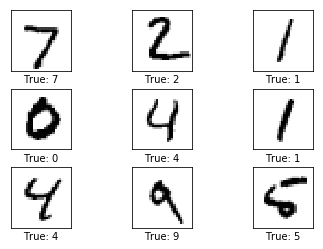

In [97]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# TensorFlow

El propósito de TensorFlow es crear grafos computacionales (_computational graph_) que pueden ser ejecutado mas eficientemente que si el cálculo fuera realizado directamente en _Python_. TensorFlow puede ser mas eficiente que NumPy porque conoce el grafo computacional completo, mientras que NumPy únicamente conoce de una operación matemática por vez.

Además, TensorFlow puede calcular autmáticamente los gradientes necesarios para optimizar las variables de los grafos y mejorar la performance del modelo. Esto se debe a que los grafos son una combinación de expresiones matemáticas simples, por lo que el gradiente del grafo se obtiene mediante la _chain rule_ de las derivadas.

Un grafo de TensorFlow consiste de las siguientes partes:

- Variables _placeholder_: usadas para la entrada de datos al grafo.
- Variables del modelo: son aquellas que se modifican durante la optimización del moderlo.
- Modelo: es esencialmente una funcion matemática que calcula una salida a partir de los datos entrada (las variables _placeholder_ y las variables del modelo).
- Funcion de costo: se utiliza para guiar la optimización de las variables.
- Método de optimización: actualiza las variables del modelo.

## Variables _Placeholder_

Las variables _placeholder_ sirven de entrada al grafo y se modifican cada vez que se ejecuta el mismo. En este caso de ejemplo, las variables _placeholder_ son las imágenes de entrada tratadas como tensores. El tipo de datos se fija a _float32_ y la forma se configura como: $ [None, img\_size\_flat] $ donde _None_ significa que el tensor puede almacenar un número arbitrario de imagenes donde cada una es un vector de tamaño $img\_size\_flat$.

In [7]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Lo siguiente es crear una variable _placeholder_ donde se asocia las imagenes de entradas con las etiquetas verdaderas. La forma de esta variable es $[None, num\_clases]$ lo que implica que puede almacenar un número arbitrario de etiquetas y cada una de ellas es un vector del largo $num\_clases$, en este caso es 10.
Finalmente se crea otra variable _placeholder_ similar, donde la clase real de cada imagen esta en formato _integer_.

In [8]:
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Variables a optimizar del modelo

Además de las variables de _placeholder_, se deben definir variables que se utilizarán para modificar y optimizar el modelo a partir de los datos de entrenamiento. Estas variables, llamadas _weights_ (pesos) y _biases_ (sesgo), se explicarán en detalle en la siguiente sección. 

La forma de la variable de pesos es $[img\_size\_flat, num\_classes]$, es decir, es un tensor de dos dimensiones con $img\_size\_flat$ filas y $num\_classes$ columnas. La variable llamada _bias_ es un tensor de una dimensión y de largo $num\_classes$.

In [9]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

## Modelo: función de calidad (_Score function_)

Esta es una función que indica la calidad de la clasificación de un dato determinado para cada una de las categorias disponibles. Si se asume que el conjunto de entrenamiento contiene $x_i \in R^D$ cada uno asociado a una etiqueta $y_i$, siendo $i = 1 \, ... \, N$ y que $y_i \in 1 \, ... \, K$. Entonces, se tienen $N$ ejemplos de dimensión $D$ y $K$ categorias. 
Por ejemplo, en el conjunto de datos de entrenamiento de MNIST se tienen $N = 55000$ imágenes, cada una de $D = 28 x 28 = 784$ pixeles. Debido a que existen 10 categorias (0 al 9), $K=10$. 

Se define a la función "score" como:
\begin{equation}
f : R^D \mapsto R^K
\end{equation}
donde se mapean los datos de entrada a los "score" de cada clase. 

### Clasificador lineal

El clasificador lineal es un modelo simple donde se multiplican las imágenes en las variables _placeholder_ con los pesos (_weight_) y se les suma el sesgo (_bias_):
\begin{equation}
s = f(x_i, W,b) = Wx_i \, + \, b
\end{equation}

En el procesamiento de imagenes, $x_i$ contiene todos los pixeles de una imagen dada en la forma de vector columna $[D \, \times \, 1]$. La matriz $W$ de tamaño $[K \, \times \, D]$ son los pesos de la función y el vector de bias $b$ de tamaño $[K \, \times \, 1]$ se denomina asi dado que influye en el resultado final pero sin interactuar con las entradas $x_i$. En conjunto, conforman los parámetros de la función y generalmente se combinan en una unica matrix de tamaño $[K \, \times \, (D + 1) ]$, esto hace necesario modificar el vector columna $X_i$ de la misma manera agregando la constante 1. 
 
\begin{equation}
s = f(x_i, W) = Wx_i
\end{equation}

Volviendo al ejemplo del conjunto de datos MNIST, $x_i$ es un vector columna de la forma $[785 \, \times \, 1]$ y la matriz de parámetros conformada por $W$ en conjunto con $b$ tiene la forma $[10 \, \times \, 785]$. Utilizando la nomenclatura de la sección "Dimensiones de los datos" [link](#inData) la forma de las imágenes de entrada es $ x = [num\_images, img\_size\_flat ]$ y la de los pesos $W = [num\_images, num\_classes]$ por lo que el resultado tiene la forma $[num\_images, num\_classes]$ luego se suma el vector de sesgos a cada fila de la matriz.

In [10]:
logits = tf.matmul(x, weights) + biases

_logits_ es una matriz de $num\_images$ filas y $num\_classes$ columnas, donde el elemento de la fila $i$ y de la columna $j$ es un estimado de la probabilidad de que la imagen de entrada $i$ pertenezca a la clase $j$. 
Nota: el nombre logits es tipico de la terminologia de _TensorFlow_.

Se puede ver que a partir de la multiplicación de matrices $W \, x_i$ efectivamente se estan evaluando 10 clasificadores en paralelo (uno por clase) donde cada clasificador es una fila de $W$. Además, aunque $(x_i,y_i)$ son fijos, se pueden modificar los parámetros $W,b$ hasta obtener valores de "score" que coincidan con la tabla de verdad durante el entrenamiento. Es decir, los parametros $(W,b)$ se aprenden durante el entrenamiento, pero cuando este finaliza, los datos de entrada pueden descartarse y únicamente mantener dichos parametros.


Sin embargo, estos valores estimados son algo complicado de interpretar por que los números son demasiado grandes o demasiado chicos. Por lo que se busca normalizar cada fila de la matriz _logits_ para que sume 1 y cada valor este limitado entre cero y uno. Para esto se utiliza la función _softmax_ que se explica en la siguiente sección.

### Softmax

El resultado de la clasificación _softmax_ puede interpretarse como la propabilidad logarítmica no normalizada de que un dato pertenezca a una clase dada. Por lo tanto, para obtener la probabilidad normalizada, es necesario exponenciar el score y dividirlo por el score total:

\begin{equation}
P(y_i \; | \; x_i ; W) = (\frac{e^{s_k}}{\sum_{j}e^{s_j} }) 
\end{equation}

Considerando que $s_j$ es el "score" que se obtiene para la clase j del elemento i: $s_j = f(x_i,W)_j$. Al sumar todas las probabilidades de un elemento frente a las distintas clases se obtiene uno, por esto se dice que está normalizada.

Se aplica la función _softmax_ al conjunto de datos utilizado _MNIST_

In [11]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Función de pérdida (_loss_) a optimizar

La función de pérdida cuantifica las diferencias entre las categorias estimadas y las categorias verdaderas. Intuitivamente, la pérdida o costo va a ser alta si la clasificación del conjunto de entrenamiento es mala y baja en caso contrario. Existen distintos métodos para calcular la perdida, los dos mas utilizados son SVM (Multiclass Support Vector Machine) y Softmax.

La funcion softmax (idealmente) nos devolvería una probabilidad de uno para la clase verdadera y probabilidad cero para las demás (falsas). Sin embargo, se necesita un unico valor que represente que tan mal se esta clasificando el conjunto de entrenamiento, por lo que se aplica la _cross-entropy_ a la función softmax.

La entropía cruzada entre la distribución "verdadera" $p$ y la obtenida mediante la función softmax $q$ se define como:

\begin{equation}
H(p,q) = - log({\sum_{x}p(x) \; log \, q(x) }) \\
q = \frac{e^{s_k}}{\sum_{j}e^{s_j} })
\end{equation}

La entropia cruzada es una funcón cuyo resultado es siempre positivo y si la predicción del modelo es identica a la salida deseada, la entropia cruzada es cero. Es también pensar la entropia cruzada, en este campo, como la distancia entre ambas distribuciones.

\begin{equation}
L_i = - log(\frac{e^{s_k}}{\sum_{j}e^{s_j} })
\end{equation}

En la siguiente imagen puede verse un ejemplo numérico (del set de datos _CIFAR10_): 

<img src="images/softmax.png" width="55%">

En la práctica, los términos $e^{s_k}$ y $\sum_{j}e^{s_j}$ pueden volverse muy grandes debido a los exponenciales. Sin embargo, dividilos puede ser numéricamente inestable. Es importante utilizar algun tipo de normalización, por lo general se multiplican ambos términos por una constante $C$:

\begin{equation}
(\frac{e^{s_k}}{\sum_{j}e^{s_j} }) = (\frac{C \, e^{s_k}}{C \, \sum_{j}e^{s_j} }) = (\frac{e^{s_k + log C}}{\sum_{j}e^{s_j + log C} })
\end{equation}

C puede ser cualquier valor y se obtendrá el mismo resultado, pero se puede utilizar para mejorar la estabilidad computacional. Una elección común es $log C = -max_j f_j$. De esta forma, se desplazan todos los valores de forma tal en que el mayor termina siendo $0$.

In [12]:
f = np.array([123, 456, 789]) # example with 3 classes and each having large scores
p = np.exp(f) / np.sum(np.exp(f)) # Bad: Numeric problem, potential blowup
print(p)
# instead: first shift the values of f so that the highest number is 0:
f -= np.max(f) # f becomes [-666, -333, 0]
p = np.exp(f) / np.sum(np.exp(f)) # safe to do, gives the correct answer
print(p)

[  0.   0.  nan]
[  5.75274406e-290   2.39848787e-145   1.00000000e+000]


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


#### Regularización

Con el objetivo de diferenciar distintos conjuntos de parámetros que den como resultado perdidas $L$ similares, se agrega un término denominado "pérdida de regularización":

\begin{equation}
L = \frac{1}{N} \; \sum_{i} \; L_i \; + \; \lambda R(W)
\end{equation}

Existen distintos métodos para realizar esta penalización, uno de los mas utilizados es la norma L2:

\begin{equation}
R(W) = \sum_{k} \sum_{l} W^2_{k,l}
\end{equation}

Como puede verser en la formula anterior, el objetivo es penalizar los pesos $W$ grandes por sobre los pequeños. Esto implica una mayor generalidad en el algoritmo, ya que, ninguna dimensión de entrada puede llegar a tener una influencia demasiado grande en los score por si sola. Se prefiere pequeñas ponderaciones en todas las dimenciones frente a algunas pocas muy fuertes, esto disminuye la tendencia al _overfitting_. 
Ejemplo: 

Si se considera la sigunte entrada $x$ y dos pesos $w_1$ y $w_2$:
\begin{align}
x &= [1,1,1,1]\\
w_1 &= [1,0,0,0]\\
w_2 &= [0.25,0.25,0.25,0.25]\\
w_1^T &= w_2^T = 1\\
\end{align}

Como puede verse, todos llevan la misma pérdida, sin embargo, la penalidad **L2** debida al peso $w_1$ es 1 mientras que la debida al $w_2$ es 0.25.

$\lambda$ es un hiperparámetro que pondera la pérdida. Es dificil de predecir y por lo general se obtiene mediante cross-validation. Como se mencionó anteriormente, la función softmax provee las "probabilidades" para cada clase, sin embargo, estas probabilidades pueden ser más difusas o abruptas dependiendo del coeficiente de regulación $\lambda$. Por ejemplo, si se supone que las porbabilidades logarítmicas no regularizadas para tres categorias son $[1, -2, 0]$, con la función softmax se calcularía:

\begin{equation}
[1, -2, 0] \rightarrow [e^1, e^{-2}, e^0] = [2.71,0.14,1] \rightarrow [0.7,0.04,0.26]
\end{equation}

Ahora, si el parametro $\lambda$ se aumenta, los pesos $W$ mas grandes serían penalizados y por lo tanto, como resultado se obtendrían pesos de menor magnitud. Por ejemplo, si disminuyen a la mitad $[0.5, -1, 0]$, la funcion sofmax computaría:

\begin{equation}
[0.5, -1, 0] \rightarrow [e^{0.5}, e^{-1}, e^0] = [1.65,0.37,1] \rightarrow [0.55,0.12,0.33]
\end{equation}

Donde las probabilidades ahora son mas difusas. En el limite, donde los pesos tienden a numeros chicos debido a penalidades muy fuertes de $\lambda$, las probabilidades tienden a la uniformidad.

Agregando el término de regularización a la ecuación de pérdida, se obtiene:

\begin{equation}
L_i = - log(\frac{e^{s_k}}{\sum_{j}e^{s_j} }) + \sum_{k} \sum_{l} W^2_{k,l}
\end{equation}

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. __The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.__

TensorFlow contiene funciones para calcular la entropia cruzada. Notar que se utilizan los valores de la variable logits por que se calcula el softmax internamente. La siguiente API aplica la función _softmax_ y la entropia cruzada al resultado de $Wx_i \, + \, b$

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

Una vez calculada la entropia cruzada para la clasificación de cada imagen, es decir, se midió que tan bien el modelo se comporta para cada imagen individualmente. Sin embargo, se necesita un valor que pueda analizar el comportamiendo del modelo para todo el conjunto de entrenamiento. Entonces, simplemente se obtiene la media de la entropia cruzada de cada imagen:

In [14]:
cost = tf.reduce_mean(cross_entropy)

## Optimización

A partir de las funciones de _score_ y _loss_, es necesario generar un proceso para elegir el conjunto de parámetros $W$ que minimice la función de pérdida. La optimización es un proceso estocastico e iterativo, donde en cada paso se intenta minimizar la función de pérdida. Para computar la mejor dirección en la que se debe modificar el conjunto de parámetros $W$ y así minimizar la función de pérdida, se utiliza el gradiente de la función de perdida. En una dimensión, la pendiente de la función es el ritmo de cambio instantaneo en cualquier punto, el gradiente es una generalizacion de la pendiente para funciones con más de una dimensión. Es decir, es un vector de pendientes para cada dimensión en el espacio de entrada (vector de derivadas parciales).

### Gradient Decent

Obtener el gradiente de la función de perdidas implica obtener la derivada parcial respecto a cada uno de los parametros $W$. El procedimiento de evaluar el gradente y luego actualizar los parámetros se denomina _Gradient Descent_. El siguiente código muestra una versión simplificada (_vanilla_) del _loop_ que se encuentra en todas las bibliotecas de redes neuronales. 

In [ ]:
# Vanilla Gradient Descent

while True:
  weights_grad = evaluate_gradient(loss_fun, data, weights)
  weights += - step_size * weights_grad # perform parameter update

Cuando el conjunto de entrenamiento es muy grande, es muy costoso evaluar la función de pérdida en todos los datos únicamente para actualizar los parámetros. Una aproximación muy utilizadas es computar el gradiente para un lote aleatorio de datos que cambia en cada iteración (_Minibatch Gradient Descent_). El tamaño de este lote es un hiperparámetro, no es común que se obtenga por validación cruzada sino que depende de la cantidad de memoria disponible.

In [ ]:
# Vanilla Minibatch Gradient Descent

while True:
  data_batch = sample_training_data(data, 256) # sample 256 examples
  weights_grad = evaluate_gradient(loss_fun, data_batch, weights)
  weights += - step_size * weights_grad # perform parameter update

La versión extrema de este optimizador, es cuando el subconjunto (_batch_) únicamente contiene un ejemplo, este proceso se denomina _stochastic Gradient Descent (SGD)_. Es poco común de ver, debido a las optimizaciones de código vectorial. Es computacionalmente mas efectivo evaluar el gradiente de 100 ejemplos que el gradiente de un ejemplo 100 veces. Suele referirse (erroneamente) tambien con este nombre al método _Minibatch Gradient Descent_.

## Backpropagation

Como se mencionó, para poder aplicar _Gradient Decent_ es necesario contar con el gradiente de la función de pérdidas, dado que es la forma más eficiente de aplicar este algoritmo de optimización. Sin embago, para algunas funciones de pérdidas, esto puede ser dificil de resolver. _Backpropagation_ es un método de computar gradientes de expresiones a través de la aplicación de la _chain rule_, donde complejas funciones se resuelven dividiendolas en expresiones más sencillas hasta que cada una de ellas es fácil de resolver.
Si se considera la expresión $f(x,y,z) = (x + y)z$ a modo de ejemplo, lo primero que se hace es dividirla en dos: $q = x + y$ y $f = qz$. Calcular las derivas de ambas expresiones por separado es sencillo: 

\begin{align}
\frac{\partial f}{\partial q} &= z \\
\frac{\partial f}{\partial z} &= q \\
\frac{\partial q}{\partial x} &= 1 \\
\frac{\partial q}{\partial y} &= 1 \\
\end{align}

La _chain rule_ implica que se deben conectar estas expresiones mediante muliplicación:

\begin{align}
\frac{\partial f}{\partial x} &= \frac{\partial f}{\partial q} \frac{\partial q}{\partial x} \\
\frac{\partial f}{\partial y} &= \frac{\partial f}{\partial q} \frac{\partial q}{\partial y} \\
\frac{\partial f}{\partial z} &= \frac{\partial f}{\partial q} \frac{\partial q}{\partial z} \\
\end{align}

<img src="images/backprop.png" width="60%">

In [15]:
# set some inputs
in_x = -2; in_y = 5; in_z = -4

# perform the forward pass
q = in_x + in_y # q becomes 3
f = q * in_z # f becomes -12
print("q = " + str(q) + "\nf = " + str(f))
# perform the backward pass (backpropagation) in reverse order:
# first backprop through f = q * z
dfdz = q # df/dz = q, so gradient on z becomes 3
dfdq = in_z # df/dq = z, so gradient on q becomes -4
print("df/dz = " + str(dfdz) + "\ndf/dq = " + str(dfdq))
# now backprop through q = x + y
dfdx = 1.0 * dfdq # dq/dx = 1. And the multiplication here is the chain rule!
dfdy = 1.0 * dfdq # dq/dy = 1
print("df/dx = " + str(dfdx) + "\ndf/dy = " + str(dfdy))

q = 3
f = -12
df/dz = 3
df/dq = -4
df/dx = -4.0
df/dy = -4.0


Cada compuerta en el diagrama a partir de las entradas computa dos cosas:
1. El valor de salida (_forward_) 
2. El gradiente local (_backward_)

Se debe notar que las compuertas pueden hacer esto completamente independientemente del resto del circuito. Entonces, una vez que finalizó la pasada hacia adelante (_forward_), durante _backpropagation_ se calcula el gradiente local al yendo de atrás hacia adelante. La _chain rule_ establece que se debe multiplicar los gradientes locales hacia todas las entradas.

### Función sigmoid

Una función de activación que se utiliza en la neuronas, como se vera más adelante, es la función sigmoid:

\begin{equation}
f(w,x) =  \frac{1}{1 + e^{-(w_0x_0+w_1x_1+w_2)}}
\end{equation}

cuyo grafo se muestra a continuación:

<img src="images/sigmoidGrafo.png" width="55%">

Si simplificamos la función con una única entrada para facilitar los calculos, se obtiene:

\begin{align}
\sigma (x) &=  \frac{1}{1 + e^{-x}} \\
\frac{d\sigma (x)}{dx} &= \frac{e^{-x}}{(1 + e^{-x})^2} = \left( \frac{1 + e^{-x} - 1}{1 + e^{-x}}\right) \left( \frac{1}{1 + e^{-x}} \right) = (1 - \sigma(x))\sigma(x)
\end{align}

Como puede verse, es posible simplificar el gradiente antes de aplicar _backpropagation_, la neurona quedaria como se ve en el siguiente código:

In [16]:
w = [2,-3,-3] # assume some random weights and data
x = [-1, -2]

# forward pass
dot = w[0]*x[0] + w[1]*x[1] + w[2] #Intermediate varible for dot product between w and x
f = 1.0 / (1 + math.exp(-dot)) # sigmoid function

# backward pass through the neuron (backpropagation)
ddot = (1 - f) * f # gradient on dot variable, using the sigmoid gradient derivation
dx = [w[0] * ddot, w[1] * ddot] # backprop into x
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] # backprop into w

## Actualización de parámetros

Una vez que se calculó el gradiente mediante _backpropagation_, se lo utiliza para actualizar los parámetros. Existen varias formas de realizar esta actualización, la forma más sencilla es cambiarlos en la dirección contraria del gradiente, ya que, el gradiente indica la dirección en que aumenta pero se necesita minimizar la función de pérdida. Asumiendo que $x$ es el vector de parámetros y el gradiente calculado es $dx$:

In [ ]:
# Vanilla update
x += -learning_rate * dx

donde $learning\_rate$ es un hiperparámetro constante. Cuando se evalua el set de entrenamiento completo, y $learning\_rate$ es lo suficientemente estamos seguros que la actualización mejorará la función de pérdida.

### Actualización mediante _Momentum_

Este método logra una mejor convergencia en redes neurnoales profundas y que modela la función de pérdida como la altura de un terreno montañoso. Por lo tanto existe una energía potencial $U = mgh$, es decir, la energía potencial es directamente proporcional a la altura. Se inicializa los parámetros con valores aleatorios, lo que equivale a una partícula con velocidad incial cero en un punto cualquiera. El proceso de optimización puede verse como una simulación de una partícula (vector de parámetros) movendose por el terreno.

Como la fuerza en la partícula esta relacionada con el gradiente de la energía potencial $F = -\nabla U$, y además, $F = ma$, por lo que el gradiente negativo es proporcional a la aceleracion de la partícula. A diferencia de la actualización SGD, el gradiente afecta indirectamente la posición de la partícula, a través de la velocidad:

In [ ]:
# Momentum Update
v = mu * v - learning_rate * dx # intagrate velocity
x += v # integrate position

La variable de la velocidad $v$ se inicializa a cero. Aunque a la variable $mu$ se la llama _momentum_, fisicamente es mas concistente con el concepto del coeficiente de fricción. Esta variable, amortigua la velocidad y reduce la energía cinética del sistema, o de otra forma, la partícula no se frenaria al llegar al fondo de la colina. Existe una mejora de este método de actualización llamado _Nesterov Momentum_ el cual garantiza mejor convergencia.

### Métodos adaptativos de _learning rate_ por parámetros

Los métodos anteriores modifican el _learning rate_ en forma global y equitativa para todos los parámetros.

#### Adagrad

In [ ]:
# Adagrad
cache += dx**2
x += -learning_rate * dx / (np.sqrt(cache) + eps)

La variable $cache$ tiene el mismo tamaño que $dx$, se utiliza para registrar por parámetros la suma del cuadrado del gradiente. Este valor luego se utiliza para normalizar en cada paso la actualización de los parámetros, de a uno por vez. Se debe notar que los pesos que reciben gradientes grandes tendrán su efecto en un _learning rate_ reducido, mientras que aquellos pesos que recibiran gradientes chicos o infrecuentes, tendrán su efecto en un _learning rate_ aumentado. El coeficiente _eps_ evita que haya diviciones por cero.
Este método, en el caso de las redes neuronales profundas, generalmente tienen un efecto demasiado agresivo y detiene le aprendisaje demasiado temprano.

#### RMSprop
RMSprop ajusta el método Adagrad para reducir la agresividad monotónica del desenso del _learning rate_. En particular, utiliza un promedio móvil del cuadrado del gradiente:

In [ ]:
cache = decay_rate * cache (1 - decay_rate) * dx**2
x += -learning_rate * dx / (np.sqqrt(cache) + eps)

$decay\_rate$ es un hiperparámetro (típicamente entre los valores 0.9, 0.99,0.999). Aunque la actualización de $x$ es idéntica al método Adagrad, el calculo de $cache$ es completamente distinto. RMSprop continúa modulando el _learning rate_ de cada peso basado en la magnitud de los gradientes, pero a diferencia del Adagrad, las actualizaciones no se hacen monotónicamente mas chicas.

#### Adam

Este método combina RMSprop con _momentum_. La actualización, en forma simplificada es:

In [ ]:
m = beta1*m + (1 - beta1) * dx
v = beta2*v + (1 - beta2) * dx**2
x += -learning_rate * m /(np.sqrt(v) + eps)

La actualización es igual a la  del RMSProp, excepto por que se utiliza una versión suavizada de $m$ en lugar del vector gradiente $dx$ que puede ser muy ruidoso. Los valores recomendados de los hiperparametros son:
- $eps = 1e-8$
- $beta1 = 0.9$
- $beta2 = 0.999$

La actualización Adam completa incluye un mecanismo de corrección de sesgo (_bias_) que compensa al inicio, cuando los vectores $m$,$v$ son cero. Haciendo que la actualización sea función de las iteraciones.
__Este algoritmo es el que se recomienda utilizar por defecto__, aunque en ciertos casos es recomendable probar algunos otros como _SGD + Nesterov Momentum_. 


<img src="images/opt1.gif" width="40%">
<img src="images/opt2.gif" width="40%">


Image credit: Alec Radford (https://twitter.com/alecrad)

En el siguiente código, se selecciona que optimizador se utilizará en el proceso de optimización. Luego, se implementa una función llamada _optimize_ quee nos permite controlar cuantas iteraciones de optimización se realizán. En cada iteración se se obtiene un nuevo _batch_ de datos de entrenamiento y luego _TensorFlow_ ejecuta la optimización para esas muestras del entrenamiento.

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.5).minimize(cost)

In [16]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

## Sesión de TensorFlow 


Es importante notar que hasta ahora no se realizo ningun cálculo en TensorFlow, únicamente se crearon los objetos de TensorFlow. Para poder ejecutarlo, es necesario primero crear una sesión e inicializar las variables de pesos y sesgos en cero.

In [17]:
session = tf.Session()
session.run(tf.global_variables_initializer())

Como se mencionó anteriormente, el set de entrenamiento contiene 50.000 imágenes, esto ocaciona que el tiempo de calculo del gradiente para todas estas imágenes sea demasiado grande. Por lo que se decirde usar un sub-conjunto (_batch_) de 100 imágenes para cada iteración de la optimización.

In [18]:
batch_size = 100

Además, se crea la variable $feed\_dict\_test$ la cual es usada como entrada al grafo de _TensorFlow_, se deben utilizar los nombres correctos de los nodos _placeholder_ creados.

In [20]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

### Presición en la clasificación antes de realizar optimizaciones

La presición en el set de test es del 9.8%, esto se debe a que el modelo únicamente fue inicializado pero no optimizado. El 9.8% de las imágenes son el dígito cero, como el modelo se inició en cero, este es el único dígito que clasifica correctamente.

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print_accuracy()

Accuracy on test-set: 9.8%


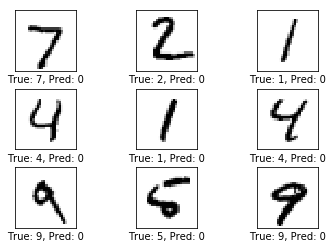

In [22]:
plot_example_errors()

### Presición en la clasificación luego de una iteración de optimización

Luego de una única iteración, el modelo incrementa su presición del 9.8% al 43.5%. Esto significa que clasifica mal 6 imagenes de cada 10, como puede verse a continuación.

Accuracy on test-set: 43.5%


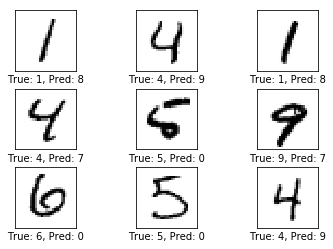

In [23]:
optimize(num_iterations=1)
print_accuracy()
plot_example_errors()

Si analizamos este clasificador como un comparador entre una imagen y un _template_, cada fila de la matriz de pesos (_weights_) $W$ es un _template_ para cada una de las clases. Si a estas filas le damos la forma de una imagen, podemos visualizar la forma en que el clasificador esta trabajando. A continuación se grafican estos pesos, donde los positivos estan en rojo y los negativos en azul. Estos pesos pueden entenderse intuitivamente como un filtro de imagen.

Por ejemplo, los pesos utilizados para determinar si una imagen muestra el digito cero, tienen una reacciòn positica a una imagen similar de un circulo (rojo) y una reacción negativa al centro del circulo y al exterior (azul).

Notar que los pesos se parecen a los digitos que se suponen deben reconocer. Esto es por que se realizó una única iteración y, por lo tanto, los pesos únicamente fueron entrenados con 100 imágenes. Luego de entrenarlo con miles, estos pesos se vuelven difícil de interpretar por que intentan reconocer todas las variaciones de como distintas personas escriben los números.

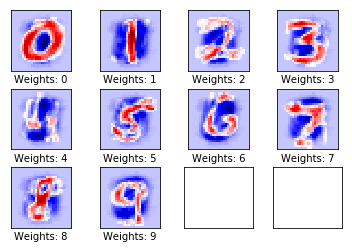

In [25]:
plot_weights()

### Presición en la clasificación luego de 1000 iteraciones de optimización

Luego de 1000 iteraciones, el modelo clasifica mal una de cada diez imágenes aproximadamente. Como se demuestra a continuación, alguna de las clasificaciones erroneas están justificadas, ya que, es muy difícil diferenciar incluso para las personas, mientras que otras son bastante obvias y deberían haber sido clasificadas correctamente. Sin embargo, este modelo simple no puede comportarse mucho mejor, es necesario un modelo más complejo.

Accuracy on test-set: 91.8%


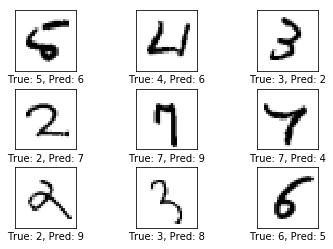

In [26]:
# We have already performed 10 iterations.
optimize(num_iterations=990)
print_accuracy()
plot_example_errors()

El modelo ahora fue entrenado con 1000 iteraciones de optimización, cada iteración usando 100 imagenes del set de entrenamiento. Debido a la gran variedad de imágenes, los pesos ahora se volvieron muy difícil de interprtar y podriamos preguntarnos si el modelo realmente entendió como los digitos se componen de lineas o si simplemente el modelo memorizó diferentes variaciones de pixeles.

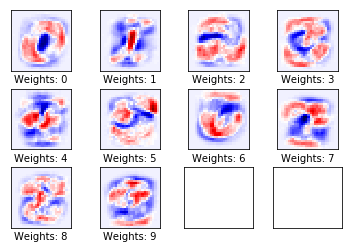

In [27]:
plot_weights()

A continuación se grafica la matriz de confusión que nos permite analizar en detalle las clasificaciones erroneas. Por ejemplo, nos muestra que las imágenes con el digito 5, a veces son confundidas con digitos como el 3, 8, o 9.

[[ 961    0    1    1    0    2   10    2    3    0]
 [   0 1104    3    2    0    1    4    2   19    0]
 [  15    5  914    9    7    1   16   12   43   10]
 [   4    1   23  888    0   29    5   15   33   12]
 [   1    1    6    1  890    0   12    2   10   59]
 [  12    3    5   25    8  745   24    6   56    8]
 [  11    3    4    1    9    7  917    1    5    0]
 [   2    6   23    6    7    1    0  929    3   51]
 [   6    5    5   11    8   13   12   11  892   11]
 [  10    4    1    5   15    8    1   12   13  940]]


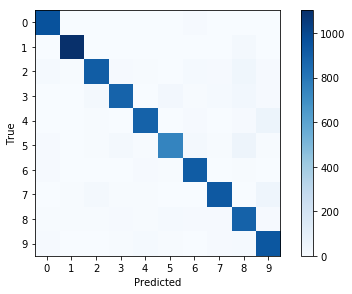

In [32]:
print_confusion_matrix()

Finalmente se cierra la sesión de _TensorFlow_ y se liberan los recursos.



In [33]:
session.close()

## Modelado de una neurona

En el modelo computacional de una neurona, las señales que viajan a través de los axones (entradas $x$) interactuan en forma de producto ($w_0x_0$) con los dentritos de otras neuronas basado en la fuerza sináptica ($w_0$) de esa sinopsis. La idea es que la fuerza sináptica (pesos $w$) se aprendan a través del control de la intensidad de influencia  de una neurona a otra. En el modelo básico, los dentritos llevan la señal al cuerpo de la célula donde se suman. Si la suma final supera un valor limite, la neurona dispara un pulso a través de su axón. En el modelo computacional, se asume, que solo la frecuencia de esta señal contiene información. Basado en este código de interpretación, se modela la frecuencia de pulsos con una función de activación. Historicamente la función de activación utilizada era la función _sigmoid_, la cual transforma un valor real a un valor entre 0 y 1.

En otras palabras, cada neurona realiza un producto punto entre las entradas y los pesos, le suma el sesgo y le aplica una no-linealidad (función de activación), en este caso la función _sigmoid_ $\sigma (x)=\frac{1}{(1+e^{−x})}$. La forma matemática de la computación hacia adelante (_fordwar_) es similar a los clasificadores lineales ya expuestos. Las neuronas tienen la capacidad de "gustarles" (activación cerca a uno) o "disgustarles" (activación cerca de cero) ciertas regiones lineales del espacio de entrada. Entonces, con una función de perdida apropiada a la salida de la neurona, se puede convertir una unica neurona en un clasificador lineal.

In [ ]:
class Neuron(object):
  # ... 
  def forward(self, inputs):
    """ assume inputs and weights are 1-D numpy arrays and bias is a number """
    cell_body_sum = np.sum(inputs * self.weights) + self.bias
    firing_rate = 1.0 / (1.0 + math.exp(-cell_body_sum)) # sigmoid activation function
    return firing_rate

### Función de activación

Las funciones de activación toman un valor de entrada y le ejercen una operación matemática fija (no lineal). En la práctica, existen muchas funciones de activación distintas, a continuación se mencional las más comunes:

- Sigmoid: Como se muestra en la siguiente imagen, esta función toma un valor y lo aplasta a un valor entre cero y uno, en particular, valores negativos grandes se convierten en cero y valores positivos grandes se convierten en 1. Esta función tiene dos desventajas, por un lado es propensa a saturar, en ese caso el gradiente se hace casi cero. Durante _bakpropagation_ este gradiente cercano a cero se multiplica por la salida de la neurona "matando" el gradiente  y el flujo de señales en la neurona sera casi nulo. Por otro lado, la salida no esta centrada en cero, esto causa que si la entrada a la neurona es siempre positiva, el gradiente durante _backpropagation_ es o siempre positivo o siempre negativo generando una dinámica muy cambiante en las actualizaciones de los pesos.

<img src="images/sigmoidFunction.png" width="70%">

- ReLU Rectified Linear Unit: Computa la función $f(x)=max(0,x)$ es decir, mientras que el valor de la entrada sea negativo, la salida vale cero, en caso contrario, el valor no se modifica. Esta función converge mas rapido al usar la optimización _stochastic gradient descent_ que las funciones _sigmoid_ y _tanh_. La implementación es más sencilla ya que no requiere funciones computacionalmente caras como exponenciales. Por otro lado, cuando existen grandes gradientes, es posible que los pesos de la neurona se actualicen de forma tal en que nunca se activa, se la considera "muerta". Utilizando un _learning rate_ apropiado, esto es menos frecuente. Existen muchas variantes de este tipo de funciones con otras características.

<img src="images/reluFunction.png" width="70%">

## Arquitectura de redes neuronales

Las redes neuronales se modelan como colecciones de neuronas que estan conectadas en grafos no ciclicos. Es decir, las salidas de algunas neuronas son entradas de otras. En lugar de un coneccionado amorfo de las neuronas, se suele organizarlas en distintos tipos de capas. El tipo de capa más común, se denomina _fully-connected_, donde todas las neuronas entre dos capas adyacentes estan conectadas , pero no asi las neuronas de las mismas capa.

<img src="images/neuralNetworkArch.png" width="70%">

Cuando se habla de una red neuronal de N capas no se cuenta la capa de entrada, por ejemplo, una red de una capa tiene la entrada mapeada directamente a la salida, es decir no tiene capas ocultas. A diferencia de las demás capas, la de salida no suele tener funciones de activación no lineales, estos es por que la ultima capa se utiliza para representar los _scores_ de cada clase.

Las métricas que usualmente se utilizan para medir el tamaño de una red neuronal son el número de neuronas y el de parámetros. Para los ejemplos de la imagen:

- La de la izquierda tiene $4 + 2 = $ neuronas sin computar las de entrada. Además tiene $[3 x 4] + [4 x 2] = 20$ pesos $w$ y $4 + 2 = 6$ sesgos (_bias_) es decir 26 parámetros en total.
- La segunda (de la derecha) tiene $4 + 4 + 1 = 9$ neuronas, $[3 x 4] + [4 x 2] = 20$ pesos y $4 + 2 = 6$ sesgos para un total de 41 parámetros.
    
Una de las principales razones por la que las redes neuronales se organizan en capas es que esta estructura facilita y eficientiza la evaluación de la red neuronal utilizando operaciones entre matrices y vectores. Continuando con el ejemplo de la imagen, en la red neuronal de tres capas, la entrada es un vector de la forma $[3 x 1]$. Los parámetros pueden almacenarse en una matriz para cada capa, los pesos de la primer capa oculta $W_1$ se almacenan en una matriz de $[4 x 3]$ y los sesgos en un vector $b_1$ de la forma  $[4 x 1]$.  Cada neurona tiene sus pesos en una de las filas de $w_1$, entonces la multiplicación np.dot($W_1$,$x$) evalúa la activación de todas las neuronas de esa capa. En forma similar, $w_2$ es una matriz de $[4 x 4]$ que almacena todas las conexiones de la segunda capa y $w_3$ es una matriz de $[1 x 4]$ para la ultima capa (de salida). 


In [ ]:
# forward-pass of a 3-layer neural network:
f = lambda x: 1.0/(1.0 + np.exp(-x)) # activation function (use sigmoid)
x = np.random.randn(3, 1) # random input vector of three numbers (3x1)
h1 = f(np.dot(W1, x) + b1) # calculate first hidden layer activations (4x1)
h2 = f(np.dot(W2, h1) + b2) # calculate second hidden layer activations (4x1)
out = np.dot(W3, h2) + b3 # output neuron (1x1)

En el código de arriba, W1,W2,W3,b1,b2,b3 son los parámetros que se deben aprender en la red. Se debe notar, que la variable de entrada no es un vector columna, sino una matriz que contiene un sub-conjunto (_batch_) de datos de entrenamiento (donde cada entrada se almacena en una columna de x). Además, se destaca que la ultima capa no aplica una función de activación.

### Arquitectura de redes neuronales en TensorFlow

A continuación, se crea una función para crear la estructura de la red neuronal a partir de los hiperparámetros:
- $num\_dense\_layers$: número de capas de la red.
- $activation$: método de activación de las neuronas, puede ser ReLU o Sigmoid.
- $learning\_rate$:  _learning rate_ del optimizador Adam.
- $num\_dense\_nodes$: número de neuronas en cada capa.

La API _keras_ tiene dos modos de construcción de redes neuronales, el mas simple es el llamado _Sequential Model_ donde las capas se van agregando en forma secuencial. Como el número de capas es un hiperparámetro, se utiliza un bucle _for_ para agregar las capas secuencialmente.

Una vez definida la arquitectura della red neuronal, es necesario agregar la función de pérdida, el optimizados y la métrica de medicion de _performance_. Esto se hace mediante la compilación del modelo. Como se estableció anteriormente, se elige como optimizador el algoritmo _Adam_, como funcón de pérdida $categorical\_crossentropy$ y como métrica de _performance_ la presición de clasificación.

In [24]:
## Create the neural network with these hyper-parameters
def create_model (num_dense_layers, activation,
                 learning_rate, num_dense_nodes):
    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(InputLayer(input_shape=(img_size_flat,)))

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(int(num_dense_layers)):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(int(num_dense_nodes[i]),
                        activation=activation,
                        name=name))
    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return(model)

## Optimización de hiperparámetros

Existen muchos hiperparámetros a elegir cuando se entrena una red neuronal en _TensorFlow_, como la cantidad de capas, la cantidad de nodos en cada capa, la función de activación, el método de optimización, el _learning-rate_ del mismo, etc. 

Una forma de encontrar buenos hiperparámetros es probando a mano cada uno hasta encontrar un conjunto que funcione adecuadamente. Esto lleva mucho tiempo y en algunos casos puede no ser muy intuitivo. Otra forma es determinar limites de busqueda para cada parámetro y computar todas las combinaciones (mediante la definici{on de un paso discreto). Esto se denomina _Grid Search_. Aunque es completamente computacional, rápidamente se vuelve muy lento ya que el número de combinaciones de paramétros crece exponencialmente al agregar mas parámetros (_Curse of Dimensionality_). Otro método es mediante una busqueda aleatoria, pero la probabilidad de encontrar combinaciones de parámetros optimas decrece a cero al aumentar el número de parámetros a encontrar.

Finalmente, se puede utilizar Particle Swarm Optimization (PSO) para encontrar una combinación de parámetros que cumpla las condiciones necesarias. __PSO__ es un método de optimización de funciones continuas no lineales inspirado en el movimiento coordinado de animales que viven en grupos, mas específicamente en enjambres. El comportamiento (velocidad y dirección) de cada individuo es el resultado de influencias cognitivas, sociales y estocásticas. El objetivo común de todos los miembros es encontrar la mejor localización en el espacio de búsqueda.

Este concepto y paradigma adhiere a 5 principios básicos de enjambres inteligentes:

 + Proximidad: la población debe ser capaz de realizar cálculos simples de espacio y tiempo.
 + Calidad: la población debe ser capaz de responder a factores de calidad del entorno.
 + Diversidad: la población no debe comprometer sus actividades a lo largo de canales excesivamente estrechos.
 + Estabilidad: la población no debe cambiar su comportamiento cada vez que el entorno cambia.
 + Adaptabilidad: la población se debe podres adaptar a cambios cuando el costo computacional lo permite.

La forma básica del algoritmo __PSO__ esta compuesta por un grupo de partículas con comunicación entre ellas, el grupo de partículas se denomina enjambre. La posición de cada una de ellas en el espacio de búsqueda representa una posible solución al problema. Cada partícula tiene una posición, velocidad y valor de _fitness_ que se determina mediante una función de optimización. La velocidad determina la próxima dirección y distancia que se debe mover la particula. El valor de _fitness_ mide la calidad del resultado propuesto por la partícula. Cada una de ellas actualiza su valor de velocidad y posición mediante la influencia del _personal best_ (mejor solución de la particula) y el _global best_ (mejor solución de todas el enjambre).

 <img src="images/psoFlow.jpg">

Ventajas

 + Concepto simple se implementa en unas pocas lineas de código.
 + Requiere operadores matemáticos simples
 + No es computacionalente costoso en términos de memoria y velocidad.
 
 ### Espacio de búsqueda
 
 Los hiperparámetros a optimizar son:
 
- $num\_dense\_layers$: número de capas de la red.
- $activation$: método de activación de las neuronas, puede ser ReLU o Sigmoid.
- $learning\_rate$: _learning rate_ del optimizador Adam.
- $num\_dense\_nodes$: número de neuronas en cada capa.

A continuación se define el espacio de búsqueda definiendo los límites y una función que verifica que la partícula se encuentre dentro de ellos.

In [25]:
## Optunity PSO optimization search space
# Activation methods
activation_cat = ['relu', 'sigmoid']
# Maximum and minimum number of nodes or neurons
max_dense_nodes = 64 
min_dense_nodes = 1
# Maximum number of layers
max_dense_layers = 5
# Maximum and minimum learning rate for the optimizer
max_learning_rate = 1e-2
min_learning_rate = 1e-6

# This function verify than the particles are inside the search space
def verify_constrains (num_dense_layers, activation,
                    learning_rate, num_dense_nodes):   
    return(num_dense_layers < max_dense_layers and
           num_dense_nodes[0] < max_dense_nodes and 
           num_dense_nodes[0] > min_dense_nodes and 
           num_dense_nodes[1] < max_dense_nodes and 
           num_dense_nodes[1] > min_dense_nodes and 
           num_dense_nodes[2] < max_dense_nodes and 
           num_dense_nodes[2] > min_dense_nodes and 
           num_dense_nodes[3] < max_dense_nodes and 
           num_dense_nodes[3] > min_dense_nodes and 
           num_dense_nodes[4] < max_dense_nodes and 
           num_dense_nodes[4] > min_dense_nodes and 
           activation < 2 and
           learning_rate < max_learning_rate and
           learning_rate > min_learning_rate)

La siguientes funciones se utilizan para calcular el valor _fitness_ de cada partícula, en este caso, el _fitness_ es la presición con que se logró clasificar el set de validación. Evaluar la precisión con que se clasifica, implica crear el modelo con los hiperparámetros que la partícula establece, entrenar el modelo y luego evaluarlo.
La creación del modelo se realiza llamando a la función $create\_model$ descripta anteriormente. Una vez que el model fue definido completamente con función de pérdida y optimizador, es necesario entrenarlo. Esta función toma dos _numpy-arrays_ y realiza tantos entrenamientos como se especifiquen en el argumento $epochs$ y utilizando el tamaño de _batch_ especificado.

Finalmente, es momento obtener la métrica de calidad de clasificación (_accuracy_), esto se hace mediante la evaluación del modelo entrenado. Para esto no se puede utilizar el conjunto de _test_, por que se obtendria un set de parámetros especificamente para este set de datos causando _overfitting_. Por esto se utiliza la técnica de _k-fold cross-validation_ donde el conjunto de entrenamiento se divide en $k$ pliegues, y luego se itera realizando $k$ entrenamientos y utilizando un pligue como validaciòn distinto en cada uno de ellos. Se obtenienen 5 resultados que luego se promedian para obtener el valor final de _fitness_.

In [112]:
## Calculate the fitness value
def calculate_fitness (num_dense_layers, activation,
                       learning_rate, num_dense_nodes):
    # number of folds
    k = 5 
    # calculate the fold size
    n_samples = len(data.train.images)
    fold_size = n_samples // k
    # Create list for saving the scores 
    scores = []
    masks = []
    for fold in range(k):
        # Creation of the tensorFlow model with the PSO particle parameters
        model = create_model(num_dense_layers, activation, learning_rate, num_dense_nodes)
        if fold == 0:
            print(activation)
            print(model.summary())
        # generate a boolean mask for the test set in this fold
        test_mask = np.zeros(n_samples, dtype=bool)
        test_mask[fold * fold_size : (fold + 1) * fold_size] = True
        # store the mask for visualization
        masks.append(test_mask)
        # create training and test sets using this mask
        X_test, y_test = data.train.images[test_mask], data.train.labels[test_mask]
        X_train, y_train = data.train.images[~test_mask], data.train.labels[~test_mask]
        # fit the classifier
        ## Training
        model.fit(x=X_train,
                  y=y_train,
                  epochs=3,
                  batch_size=128,
                  verbose=0)
        ## Evaluation
        result = model.evaluate(x=X_test,
                                y=y_test,
                                verbose=0)
        # compute the score and record it
        scores.append(result[1])
       
        print("Fold: " + str(fold))        
        print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
        # Delete the Keras model with these hyper-parameters from memory. 
        del model
        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
    print(np.abs(np.mean(scores)))
    return (np.abs(np.mean(scores)))

def create_objective_function():
    def f(num_dense_layers, activation,
          learning_rate, dense_layer0,
          dense_layer1,dense_layer2,
          dense_layer3,dense_layer4):

        num_dense_nodes = [dense_layer0,dense_layer1,dense_layer2,dense_layer3,dense_layer4]
        fitness = 10
        if verify_constrains(num_dense_layers,round(activation),learning_rate, num_dense_nodes):
            fitness = 1.0/calculate_fitness(num_dense_layers, activation_cat[round(activation)],learning_rate, num_dense_nodes)
        return fitness
    return f

 ### Optunity
 
 Optunity es una biblioteca que contiene varios optimizadores de hiperparámetros, incluyendo __PSO__. En el siguiente código, se inicializa el _solver_ con los siguientes hiperparametros del _particle swarm_:

- num_particles (int): Número de partículas
- num_generations (int): Máximo número de generaciones
- max_speed (float or None): Velocidad máxima de cada partícula
- phi1 (float): Coeficiente de aceleración que determina la influencia relativa del _local best_
- phi2 (float): Coeficiente de aceleración que determina la influencia relativa del _global best_
- kwargs ({'name': [lb, ub], ..}): Dimensiones del espacio de busqueda y sus respectivos valores máximos y mínimos

In [114]:
start_time = time.time()
f = create_objective_function()
omega = 1.0/(2.0*np.log(2))
phi = 0.5 + np.log(2)
pso = optunity.solvers.ParticleSwarm(num_particles=10,
                                     num_generations=500,
                                     max_speed=omega, 
                                     phi1=phi,phi2=phi,
                                     num_dense_layers=[1, max_dense_layers], 
                                     activation=[0, 2], 
                                     learning_rate=[min_learning_rate, max_learning_rate], 
                                     dense_layer0=[1, max_dense_nodes], 
                                     dense_layer1=[1, max_dense_nodes], 
                                     dense_layer2=[1, max_dense_nodes], 
                                     dense_layer3=[1, max_dense_nodes], 
                                     dense_layer4=[1, max_dense_nodes])
pars,details = pso.minimize(f)
end_time = time.time()
time_dif = end_time - start_time
print(pars)

sigmoid
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 43)                33755     
_________________________________________________________________
layer_dense_2 (Dense)        (None, 60)                2640      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                610       
Total params: 37,005
Trainable params: 37,005
Non-trainable params: 0
_________________________________________________________________
None
Fold: 0
acc: 95.62% loss 0.141596140798
Fold: 1
acc: 95.70% loss 0.139085072947
Fold: 2
acc: 94.93% loss 0.162478622548
Fold: 3
acc: 95.72% loss 0.147750961468
Fold: 4
acc: 96.18% loss 0.132498652659
0.956290909065
relu
_____________________________________

In [115]:
print("Time: " + str(time_dif))

num_dense_nodes = [int(pars['dense_layer0']),
                   int(pars['dense_layer1']),
                   int(pars['dense_layer2']),
                   int(pars['dense_layer3']),
                   int(pars['dense_layer4'])]

num_dense_layers = (int(pars['num_dense_layers']))
activation = activation_cat[round(pars['activation'])]
learning_rate = pars['learning_rate']

print(num_dense_layers,activation,learning_rate,num_dense_nodes)
model = create_model(num_dense_layers, activation, learning_rate, num_dense_nodes)
print(model.summary())
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=3,
          batch_size=128,
          verbose=0)
## Evaluation
result = model.evaluate(x=data.test.images,
                        y=data.test.labels,
                        verbose=0)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
# Delete the Keras model with these hyper-parameters from memory. 
del model
# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

Time: 1162.0805633068085
2 sigmoid 0.0085841259765625 [43, 60, 32, 48, 44]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 43)                33755     
_________________________________________________________________
layer_dense_2 (Dense)        (None, 60)                2640      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                610       
Total params: 37,005
Trainable params: 37,005
Non-trainable params: 0
_________________________________________________________________
None
acc: 95.92% loss 0.133506590831


## Redes neuronales convolucionales

El clasificador lineal que se mostro anteriomente, logro una presicion de aproximadamente el 91%, a continuaciòn se implementara una red nuronal convolucional simple con una presicion de aproximadamente el 99%.

Las redes convolucionales trabajan moviendo filtros de pocos pixeles a través de la imagen de entrada. Esto significa que el filtro se reutiliza para reconocer patrones en toda la imagen de entrada. Esto hace que las redes neuronales convolucionales sean mas poderosas que las redes _Fully-connected_ del mismo numero de variables. Incluso las redes neuronales convolucionales son mas rapidas de entrenar.

### Diagrama de flujo

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.
El siguiente diagrama muestra como se mueven los datos en la red neuronal convolucional que se implementará a continuación.

<img src="images/network_flowchart.png" width="70%">



La imagen de entrada es procesada en la primer capa convolucional utilizando el filtro de $5x5$ pixeles. Esto resulta en 16 nuevas imágenes, una para cada filtro de la capa. Las imagenes son sub-sampleadas por lo que la resolucion se reduce de $28x28$ a $14x14$.

Estas 16 imagágenes mas chicas, son procesadas luego por la segunda capa convolucional. Se necesitan filtros por cada uno de los 16 canales y, además, se necesitan filtros para cada canal de salida de esta capa. Hay 36 canales de salida por lo que  en total hay $16 x 36 = 576$ filtros. Las imagenes resultantes estan sub-sampleadas nuevamente a $7 x 7$ pixeles.

La salida de la segunda capa convolucional es de 36 imágenes de $7x7$ pixeles. Luego se le cambia la forma a un vector de largo $7x7x36 = 1764$ y de una dimensión, el cual se usa como entrada a una capa _fully-connected_ de 128 neuronas. Esto alimenta otra capa _fully-connected_ de 10 neuronas, una por cada clase, que se usan para determinar a que clase se corresponde la imagne, es decir, que numero esta dibujado en la imagen.

Los filtros convolucionales son inicializados con valores aleatorio, por lo que la clasificación es aleatoria. El error entre la clase predecida y la clase verdadera de la imagen es medida mediante la entropia cruzada. El optimizador, luego propaga este error hacia atras a traves de la red convolucional usando la _chain-rule_ de la diferenciacion y actualiza los pesos (filtros) para disminuir el error de clasificación. Esto se hace iterativamente miles de veces hasta que el error de clasificación es lo suficientemente chico.

Se debe destacar que la computación en _TensorFlow_ se realiza en sub-conjuntos (_batches_) de imagenes, lo que implica que el diagrama de flujo en realidad tiene una dimensión de datos más cuando se implementa en _TensorFlow_.


Convolutional Layer

The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.

The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.

In this case it appears that the filter recognizes the horizontal line of the 7-digit, as can be seen from its stronger reaction to that line in the output image.

Convolution example


<img src="images/convolution.png" width="50%">





#Importante: En el PSO tengo que usar si o si cross validation! Ver la pagina de Optunity 

Cada nodo en el grapho representa una operación matemática, mientras que los bordes del grafico representan vectores de datos (tensores) que se comunican a traves de los nodos.